# Business Valuation

This notebook showcases relevent models I've used in personal business valuation

# Data importation step

In [118]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def sigmoid(x, L, x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return y

def expo(x, L, k):
    y = L * np.exp(k*x)
    return y

def sigmoidMod(x, L, x0):
    #Fixed width parameter sigmoid function
    k = 0.10207452625761901
    y = L / (1 + np.exp(-k*(x-x0)))
    return y

#Read CSV file
import pandas
revenueAllDF = pandas.read_csv('businessRevenue.csv')

revenueDF = revenueAllDF[["Date", "Overall"]]
    
#Extract the data from the data frame
xdate = (revenueAllDF["Date"]).to_numpy()
yOver = (revenueAllDF["Overall"].astype(float)).to_numpy()
N = len(yOver)
xnum = range(N)

years = 6 #Time to IPO/Buyback

# Check against market factors

Finding correlation matrix
S&P 500 variance 209314.83812766668
Business variance 878932703.6629453
Beta -28.512183702069667


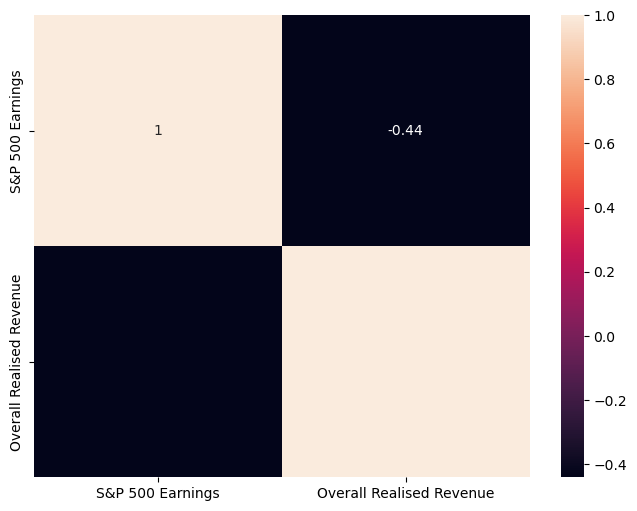

In [119]:
#cointegration with uk and us shipping trade and global growth

# Check correlation (get beta) and cointegration with the market
# Market data from here: https://www.macrotrends.net/1324/s-p-500-earnings-history

# initialize list of lists
data = [['June 2024', 5277.71],['May 2024', 5277.71], ['Apr 2024', 5035.69], ['Mar 2024', 5254.35], ['Feb 2024', 5096.27],['Jan 2024', 4845.65],
        ['Dec 2023', 4769.83],['Nov 2023',4567.80],['Oct 2023',4193.8],['Sep 2023',4288.05],['Aug 2023', 4507.66],
        ['Jul 2023',4588.96],['Jun 2023',4450.38],['May 2023',4179.83],['Apr 2023',4169.48],['Mar 2023', 4109.31],
        ['Feb 2023',3970.15],['Jan 2023',4076.6],['Dec 2022', 3839.5],['Nov 2022',4080.11],
        ['Oct 2022',3871.98],['Sep 2022',3585.62],['Aug 2022',3955],['Jul 2022',4130.29],['Jun 2022',3785.38],['May 2022',4132.15],
        ['Apr 2022',4132.15],['Mar 2022',4530.41],['Feb 2022',4373.94],['Jan 2022',4515.55]]

# Create the pandas DataFrame
SAP500df = pandas.DataFrame(data, columns=['Date', 'Earnings'])
SAP500 = SAP500df['Earnings']


print("Finding correlation matrix")
d = pandas.concat([ SAP500df, revenueAllDF], axis=1)
corr_matrix = d.corr()

#Make a heatmap of the coorelations
import seaborn as sn
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sn.heatmap(corr_matrix, annot = True, xticklabels=["S&P 500 Earnings","Overall Realised Revenue"], 
           yticklabels=["S&P 500 Earnings","Overall Realised Revenue"])

print("S&P 500 variance", np.var(SAP500))
print("Business variance", np.var(yOver))
print("Beta", -0.44 * np.sqrt(np.var(yOver))/np.sqrt(np.var(SAP500))  )
#Need to unleverage the beta: https://www.investopedia.com/ask/answers/102714/how-do-i-unlever-beta.asp

# Check stationarity

Check stationarity of overall revenue data
ADF Statistic: 2.021250686278667
p-value: 0.9986999359135448
Non-Stationary


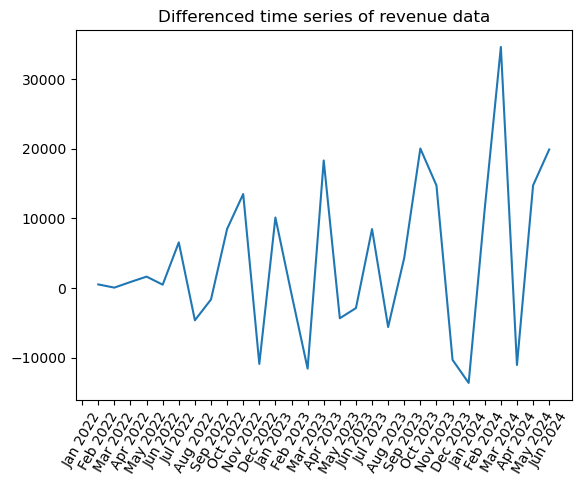

Check stationarity of differenced revenue data
ADF Statistic: -5.653321891802502
p-value: 9.74757467870392e-07
Strongly Stationary


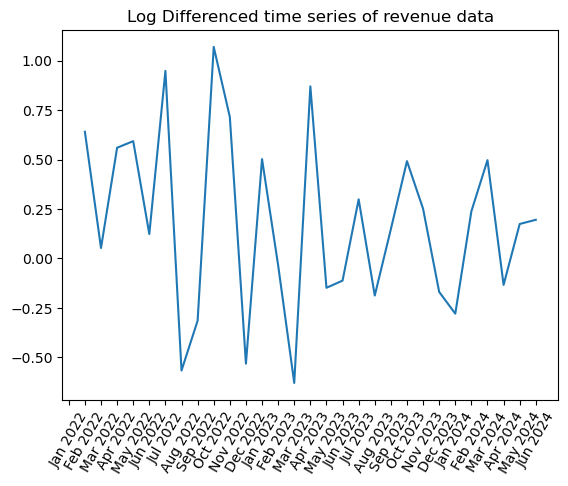

Check stationarity of log-differenced revenue data
ADF Statistic: -3.4723988278737465
p-value: 0.008724899084997621
Strongly Stationary


In [120]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    if p_value < 0.01:
        print('Strongly Stationary')
    elif p_value < 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')
 
print("Check stationarity of overall revenue data")
check_stationarity(yOver)

# Use differncing to turn into a stationary time series
diffyOverall = revenueDF["Overall"].astype(float).diff()
plt.plot(xdate, diffyOverall)
plt.title("Differenced time series of revenue data")
plt.xticks(rotation = 60)
plt.show()
print("Check stationarity of differenced revenue data")
check_stationarity(diffyOverall.dropna())

#Use log then differene. This implies an expotential type SARIMA model
diffyOverallLog = np.log(revenueDF["Overall"].astype(float).dropna()).diff()
plt.plot(xdate, diffyOverallLog)
plt.title("Log Differenced time series of revenue data")
plt.xticks(rotation = 60)
plt.show()
print("Check stationarity of log-differenced revenue data")
check_stationarity(diffyOverallLog.dropna())

# Check frequency components

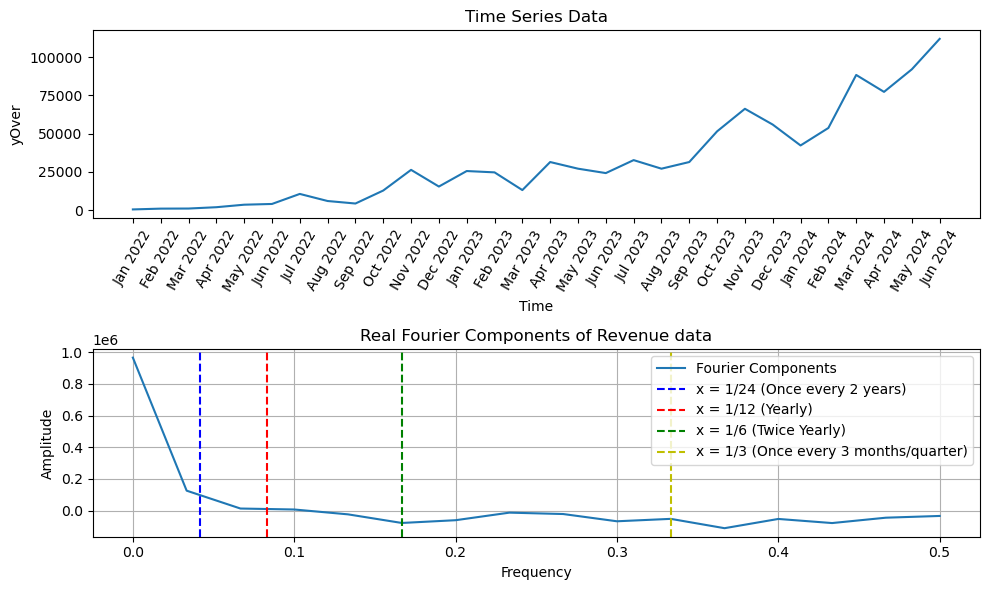

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft

# Compute the Fourier transform
yOver_rfft = rfft(yOver)

# Compute the frequencies corresponding to the Fourier components
freqs = np.fft.rfftfreq(len(yOver))

# Plot the original time series data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(xdate, yOver, label="Original Data")
plt.xticks(rotation = 60)
plt.xlabel("Time")
plt.ylabel("yOver")
plt.title("Time Series Data")

# Plot the Fourier components
plt.subplot(2, 1, 2)
plt.plot(freqs, np.real(yOver_rfft), label="Fourier Components")
plt.xlabel("Frequency")
plt.axvline(x=1/24, color='b', linestyle='--', label="x = 1/24 (Once every 2 years)")
plt.axvline(x=1/12, color='r', linestyle='--', label="x = 1/12 (Yearly)")
plt.axvline(x=1/6, color='g', linestyle='--', label="x = 1/6 (Twice Yearly)")
plt.axvline(x=1/3, color='y', linestyle='--', label="x = 1/3 (Once every 3 months/quarter)")
plt.legend()
plt.ylabel("Amplitude")
plt.title("Real Fourier Components of Revenue data")
plt.grid()

plt.tight_layout()
plt.show()
#print("A non null seasonally trend")

# Fit SARMIA Model

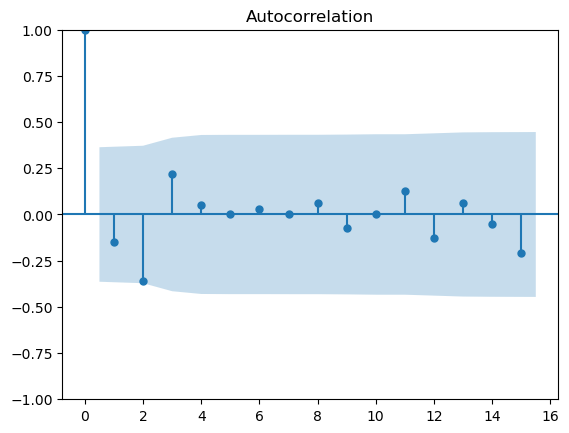

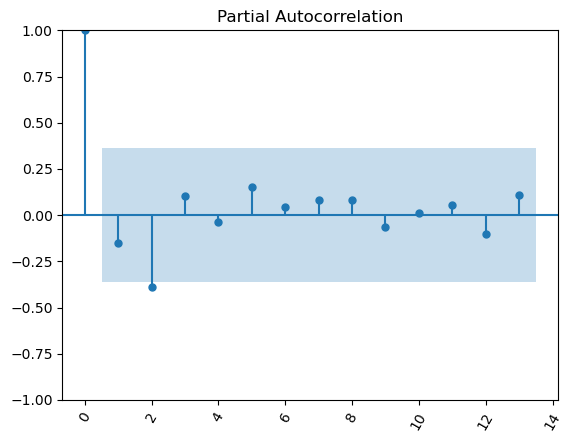

In [122]:
monthly_sales = diffyOverall.dropna()

plot_acf(monthly_sales)
plot_pacf(monthly_sales, lags=13)
plt.xticks(rotation = 60)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\op

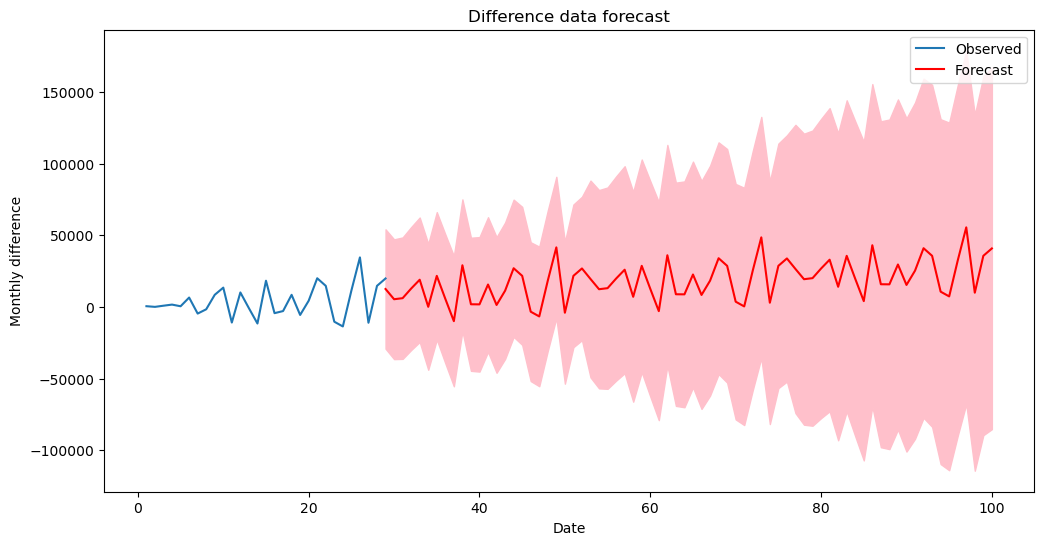

[91969.92215665788, 104493.27868041224, 109872.26996949702, 115993.88149206951, 128822.15983524919, 147814.41907747864, 147912.57843926665, 169601.5263120532, 175260.2686736967, 165344.5873193515, 194435.7077941092, 196300.0241494414, 198102.21187887178, 213751.88522823277, 215129.92347130363, 226460.53520468046, 253459.62293067196, 275162.1573657497, 271848.86070751905, 265224.64935318555, 283616.25441797794, 325184.27769215824, 321135.2243419035, 342837.74621184793, 369690.5834289962, 389201.2751774557, 401567.60128983954, 414676.5481544133, 434492.1623443209, 460471.7567878241, 467557.25100611156, 496233.5323329402, 508879.6104603269, 505951.26705416205, 542029.7207111056, 550881.3732323521, 559670.8974212601, 582307.9060367044, 590673.2799472645, 608991.2268294283, 642977.6491994803, 671667.5189240727, 675341.557900131, 675704.6835825436, 701083.6233723812, 749638.9791891697, 752577.2631475173, 781267.119342336, 815107.290590795, 841605.3175639595, 860958.9784996426, 881055.2607062

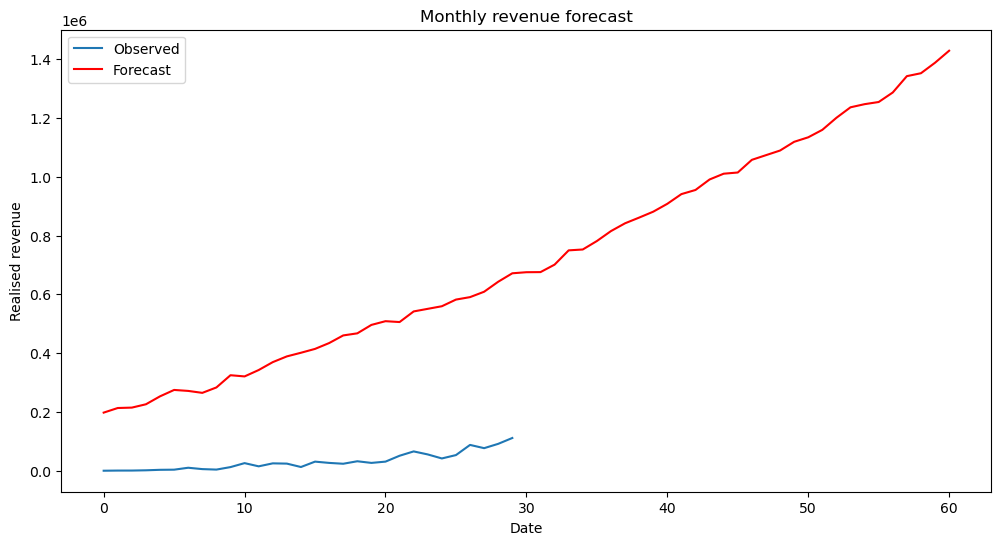

In [123]:
# Define SARIMA parameters from the graphs above
# For data no SARIMA model fitted well!
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # Assuming monthly seasonality
 
# Fit the SARIMA model
model = SARIMAX(monthly_sales, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(method_kwargs={'maxiter': 10})
model
results

forecast_periods = 12*6  # Forecast the next 12 months 
forecast = results.get_forecast(steps=forecast_periods) 
forecast_mean = forecast.predicted_mean 
forecast_ci = forecast.conf_int() 
  
# Plot the forecast 
plt.figure(figsize=(12, 6)) 
plt.plot(monthly_sales, label='Observed') 
plt.plot(forecast_mean, label='Forecast', color='red') 
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink') 
plt.title("Difference data forecast") 
plt.xlabel("Date") 
plt.ylabel("Monthly difference") 
plt.legend() 
plt.show()

# Make the next few months worth of revenue
newValues = [yOver[-2]]

for i in range(len(forecast_mean)):
    newValues.append(newValues[i] + forecast_mean.iloc[i])
    
print(newValues)

# Plot the forecast 
plt.figure(figsize=(12, 6)) 
plt.plot(yOver, label='Observed') 
plt.plot(newValues[12:], label='Forecast', color='red') 
#plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink') 
plt.title("Monthly revenue forecast") 
plt.xlabel("Date") 
plt.ylabel("Realised revenue") 
plt.legend() 
plt.show()

In [124]:
discount = 0.0378/12 #Current yield of a 10-year treasury
value = 0

print("Assume the revenue is the free cashflow. Unknown ITDA!")
for i in range(N,12*years*1):
    value += ( newValues[i] / pow((1 + discount),i-N) )

print("Using a discounted cash flow model for the next",years,"years with a current annual discount rate of", round(discount*12*100,3),"%")
print("Market cap £", round(value/pow(10,6),3), "Million")
print("Market cap £", round(value/pow(10,9),3), "Billion")
numShares = 11
totalNumShares = 57490
valueShare = (value/totalNumShares)
orignal = 354.6
print("")
print("Analysis of shares")
print("Original value of 1 share £", orignal)
print("Number of shares:", numShares)
print("Value of 1 share in DCF model £", round(valueShare,4) )
percentRaise = (valueShare-orignal)/orignal
print("Percentage return:", round(percentRaise*100,3), "%")
print("Excess return over discount",round( (percentRaise-(12*discount) )*100, 3) ,"%")
sarimaMultiple = (valueShare)/orignal
print("Return multipler", sarimaMultiple)

Assume the revenue is the free cashflow. Unknown ITDA!
Using a discounted cash flow model for the next 6 years with a current annual discount rate of 3.78 %
Market cap £ 34.507 Million
Market cap £ 0.035 Billion

Analysis of shares
Original value of 1 share £ 354.6
Number of shares: 11
Value of 1 share in DCF model £ 600.2258
Percentage return: 69.268 %
Excess return over discount 65.488 %
Return multipler 1.692684055690725


# Fit a Sigmoid Model

## Pure Sigmoid model

Overall Limit parameter (L) 26277.067318908612
Overall Inflection (x0) 8.63438579574617
Overall Scale parameter (k) 0.4735820474490472


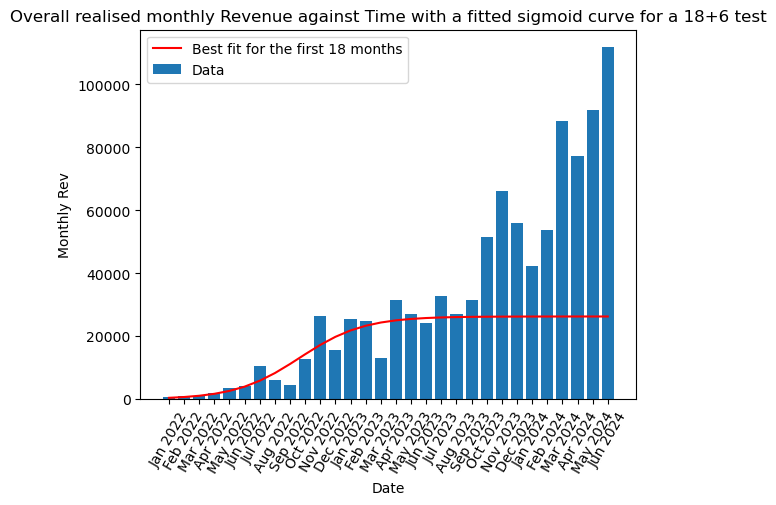

MSE for final 6 months 943882697.3765513


In [125]:
#
# Do a 18+6 and 20+4 backtest
#

# 18+6 back test a sigmoid curve
popt, pcov = curve_fit(sigmoid, xnum[:18], yOver[:18], p0=[50000,100,0.01] ,method='lm')
print("Overall Limit parameter (L)", popt[0])
print("Overall Inflection (x0)", popt[1])
print("Overall Scale parameter (k)", popt[2])

plt.bar(xdate, yOver) #Known realised rev. For 18 months
plt.plot(xdate, sigmoid(xnum, popt[0], popt[1], popt[2]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit for the first 18 months","Data"])
plt.title("Overall realised monthly Revenue against Time with a fitted sigmoid curve for a 18+6 test")
plt.show()
print("MSE for final 6 months", np.square(np.subtract(yOver[6:], sigmoid(xnum[6:], popt[0], popt[1], popt[2]))).mean() )

Overall Limit parameter (L) 28489.914869902303
Overall Inflection (x0) 9.136477920177986
Overall Scale parameter (k) 0.4087279275189876


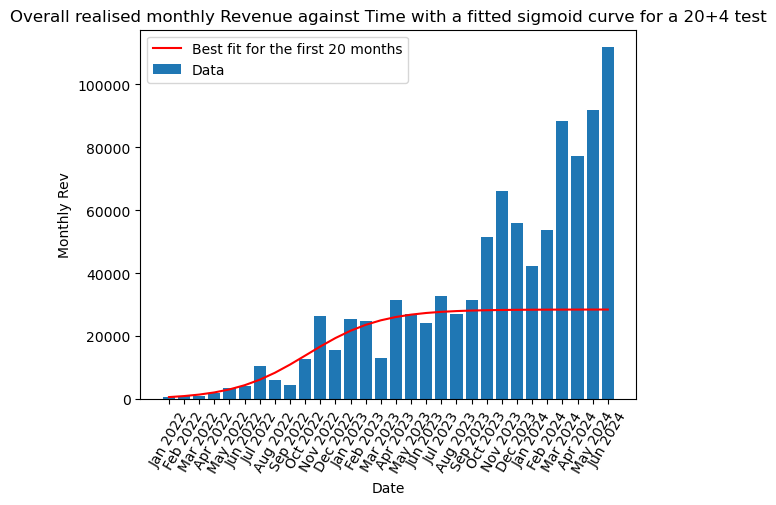

MSE for final 4 months 804341597.4112871


In [126]:
#20+4 back test a sigmoid curve
popt, pcov = curve_fit(sigmoid, xnum[:20], yOver[:20], p0=[50000,100,0.01] ,method='lm')
print("Overall Limit parameter (L)", popt[0])
print("Overall Inflection (x0)", popt[1])
print("Overall Scale parameter (k)", popt[2])

plt.bar(xdate, yOver) #Known realised rev. For 18 months
plt.plot(xdate, sigmoid(xnum, popt[0], popt[1], popt[2]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit for the first 20 months","Data"])
plt.title("Overall realised monthly Revenue against Time with a fitted sigmoid curve for a 20+4 test")
plt.show()
print("MSE for final 4 months", np.square(np.subtract(yOver[4:], sigmoid(xnum[4:], popt[0], popt[1], popt[2]))).mean() )

## Exponential+Sigmoid Model

Overall Limit parameter (L) 3993.768257586328
Overall Scale parameter (k) 0.12118684209232625


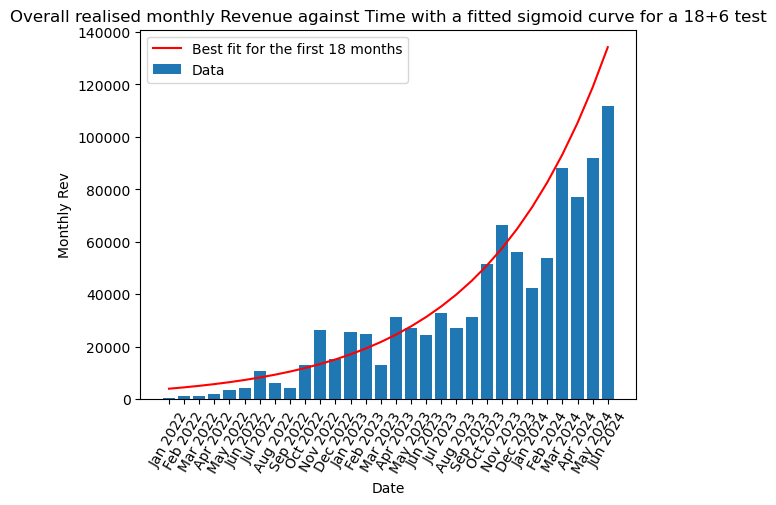

MSE for final 6 months 201407146.26819226


In [127]:
#18+6 back test an expo curve
popt, pcov = curve_fit(expo, xnum[:18], yOver[:18], p0=[50000,0.01] ,method='lm')
print("Overall Limit parameter (L)", popt[0])
print("Overall Scale parameter (k)", popt[1])

plt.bar(xdate, yOver) #Known realised rev. For 18 months
plt.plot(xdate, expo(xnum, popt[0], popt[1]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit for the first 18 months","Data"])
plt.title("Overall realised monthly Revenue against Time with a fitted sigmoid curve for a 18+6 test")
plt.show()
print("MSE for final 6 months", np.square(np.subtract(yOver[6:], expo(xnum[6:], popt[0], popt[1]))).mean() )

Overall Limit parameter (L) 4724.609538891188
Overall Scale parameter (k) 0.10473752321838556


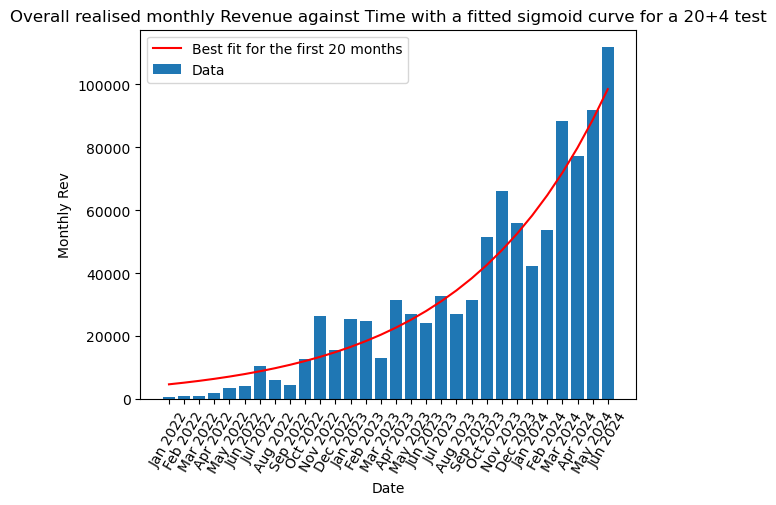

MSE for final 4 months 73768258.06628504


In [128]:
#20+4 back test an expo curve
popt, pcov = curve_fit(expo, xnum[:20], yOver[:20], p0=[50000,0.01] ,method='lm')
print("Overall Limit parameter (L)", popt[0])
print("Overall Scale parameter (k)", popt[1])

plt.bar(xdate, yOver) #Known realised rev. For 18 months
plt.plot(xdate, expo(xnum, popt[0], popt[1]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit for the first 20 months","Data"])
plt.title("Overall realised monthly Revenue against Time with a fitted sigmoid curve for a 20+4 test")
plt.show()
print("MSE for final 4 months", np.square(np.subtract(yOver[4:], expo(xnum[4:], popt[0], popt[1]))).mean() )

## Fit lowest MSE model

Expo Limit parameter (L) 4384.499213047001
Expo Scale parameter (k) 0.10936463704684307


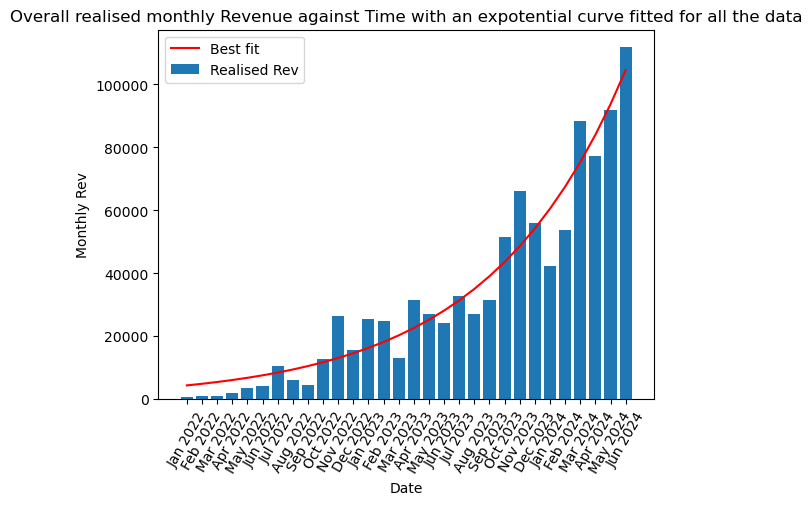

Modified sigmoid Limit parameter (L) 15154406421.155651
Modified sigmoid posiiton (x0) 145.7312349903456


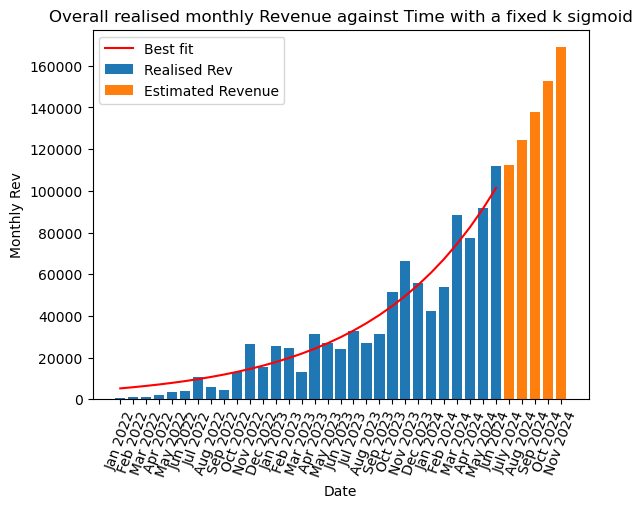

In [129]:
#Curve fit Expo as that had the lowest MSE for the back-tested models
popt, pcov = curve_fit(expo, xnum, yOver, p0=[5000000,0.001] ,method='lm')
print("Expo Limit parameter (L)", popt[0])
print("Expo Scale parameter (k)", popt[1]) #Need to put this in the sigmoidMod function
#Plot the expo data
plt.bar(xdate, yOver) #Known realised rev
plt.plot( xdate, expo(xnum, popt[0], popt[1]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit", "Realised Rev"])
plt.title("Overall realised monthly Revenue against Time with an expotential curve fitted for all the data")
plt.show()

#
#Use the expo to fit a sigmoid. Sigmoid give bound expotential growth and typically business growth pattern
#

popt, pcov = curve_fit(sigmoidMod, xnum, yOver, p0=[50000000,30] ,method='lm', maxfev=20000)
print("Modified sigmoid Limit parameter (L)", popt[0])
print("Modified sigmoid posiiton (x0)", popt[1])

#Plot predicted data
xx = ['July 2024', 'Aug 2024', 'Sep 2024', 'Oct 2024', 'Nov 2024'] #Need to fix this data frame creation to make adaptable
xy = []
for i in range(N,N+5):
    xy.append( sigmoidMod(i, popt[0], popt[1]) )

#Plot sigmoid
plt.bar(xdate, yOver) #Known realised rev
xy = np.array(xy)
plt.bar(xx, xy)
plt.plot( xdate, sigmoidMod(xnum, popt[0], popt[1]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 70)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit", "Realised Rev", "Estimated Revenue"])
plt.title("Overall realised monthly Revenue against Time with a fixed k sigmoid")
plt.show()

## DCF Analysis of Modified Sigmoid model

In [130]:
discount = 0.0378/12 #Current yield of a 10-year treasury
value = 0

print("Assume the revenue is the free cashflow. Unknown ITDA!")
for i in range(N,12*years*1):
    value += ( (sigmoidMod(i, popt[0], popt[1])) / pow((1 + discount),i-N) )

print("Using a discounted cash flow model for the next",years,"years with a current annual discount rate of", round(discount*12*100,3),"%")
print("Market cap £", round(value/pow(10,6),3), "Million")
print("Market cap £", round(value/pow(10,9),3), "Billion")
print("Monthly revenue £", round(popt[0],4) )
print("Yearly revenue £", round(12*popt[0],4) )
print("Yearly revenue £", round(12*popt[0]/pow(10,9),1) ,"Billion")
numShares = 11
totalNumShares = 57490
valueShare = (value/totalNumShares)
orignal = 354.6
print("")
print("Analysis of shares")
print("Original value of 1 share £", orignal)
print("Number of shares:", numShares)
print("Value of 1 share in DCF model £", round(valueShare,4) )
print("Limiting cash flow value per share £", round(popt[0]/totalNumShares,4) )
percentRaise = (valueShare-orignal)/orignal
print("Percentage return:", round(percentRaise*100,3), "%")
print("Excess return over discount",round( (percentRaise-(12*discount) )*100, 3) ,"%")
sigmoidMultiple = (valueShare)/orignal
print("Return multipler", (valueShare)/orignal)

Assume the revenue is the free cashflow. Unknown ITDA!
Using a discounted cash flow model for the next 6 years with a current annual discount rate of 3.78 %
Market cap £ 67.713 Million
Market cap £ 0.068 Billion
Monthly revenue £ 15154406421.1556
Yearly revenue £ 181852877053.8678
Yearly revenue £ 181.9 Billion

Analysis of shares
Original value of 1 share £ 354.6
Number of shares: 11
Value of 1 share in DCF model £ 1177.8292
Limiting cash flow value per share £ 263600.7379
Percentage return: 232.157 %
Excess return over discount 228.377 %
Return multipler 3.3215713751678546


# EBITDA Multiples

In [131]:
#Compute a last 12 months average of revenue. Assuming Revenue = EBITDA for the company

averageEBITDA = (yOver[-12:]).mean()

#Find multiple in list
#https://www.equidam.com/ebitda-multiples-trbc-industries/
#Between 6.12 and 13.1

minBusinessVal = 6.12 * averageEBITDA
maxBusinessVal = 13.1 * averageEBITDA

print("Min", minBusinessVal)
print("Max", maxBusinessVal)

minShare = minBusinessVal / totalNumShares
maxShare = maxBusinessVal / totalNumShares

print("Min EBITA Return", (minShare)/orignal )
print("Max EBITA Return", (maxShare)/orignal )

Min 372498.44236061047
Max 797341.4370790845
Min EBITA Return 0.018272308588580668
Max EBITA Return 0.03911229452784424


# Fit a LSTM Model

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fv2%2Fresize%3Afit%3A1200%2F1*o9R4WZZulh7-vtfUPQsEjQ.png&f=1&nofb=1&ipt=551348ec58740c96161203c9331324e2f6a7a2f25df6486e5c5fc9601d0cc735&ipo=images" width="200" height="100">

In [132]:
# Create a new dataframe to model the difference
df_diff = revenueDF.copy() #add previous sales to the next row
df_diff['prev_sales'] = df_diff['Overall'].shift(1) #drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Overall'] - df_diff['prev_sales'])

# Create dataframe for transformation from time series to supervised. Use last 12 months to predict
df_supervised = df_diff.drop(['prev_sales'],axis=1)#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

#Import statsmodels.formula.api
import statsmodels.formula.api as smf# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2', data=df_supervised)# Fit the regression
model_fit = model.fit()# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

#import MinMaxScaler and create a new dataframe for LSTM model. Do a 80/20 train/test split
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['Overall','Date'],axis=1)#split train and test set
train_set, test_set = df_model[0:20].values, df_model[-20:].values

# Apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

# Reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

0.10025209541324431


In [133]:
#import Keras
import keras
#import tensorflow as tf
from keras.layers import Lambda, Activation, Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Build the LSTM Model
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential()
model.add( LSTM(4, stateful=True) ) #batch_input_shape=(1, X_train.shape[1], X_train.shape[2])
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4193
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3830
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3640
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3477
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3332
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3202 
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3084 
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2977
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2880
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2792 
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2713
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2640 
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2575 
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2516
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2463

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0611 
Epoch 82/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0592 
Epoch 83/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0573
Epoch 84/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0554
Epoch 85/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0536 
Epoch 86/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0518 
Epoch 87/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0501
Epoch 88/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0484
Epoch 89/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0467
Epoch 90/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 
Epoch 91/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0435 
Epoch 92/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419 
Epoch 93/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0404 
Epoch 94/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 
Epoch 95/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0375

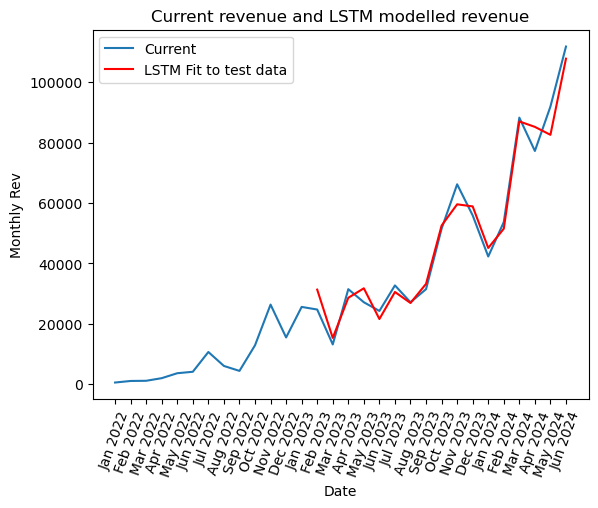

In [134]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    #print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

#create dataframe that shows the predicted sales
result_list = []
#print(revenueDF)
sales_dates = list(revenueDF[-18:].Date)
act_sales = list(revenueDF[-18:].Overall)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['Pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['Date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pandas.DataFrame(result_list) #for multistep prediction, replace act_sales with the predicted sales

#Plot
#merge with actual sales dataframe
df_sales_pred = pandas.merge(revenueDF,df_result,on='Date',how='left')#plot actual and predicted

#matplot
plt.plot(revenueDF['Date'], revenueDF['Overall'])
plt.plot( df_result['Date'], df_result['Pred_value'] , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 70)
plt.ylabel("Monthly Rev")
plt.legend(["Current", "LSTM Fit to test data"])
plt.title("Current revenue and LSTM modelled revenue")
plt.show()

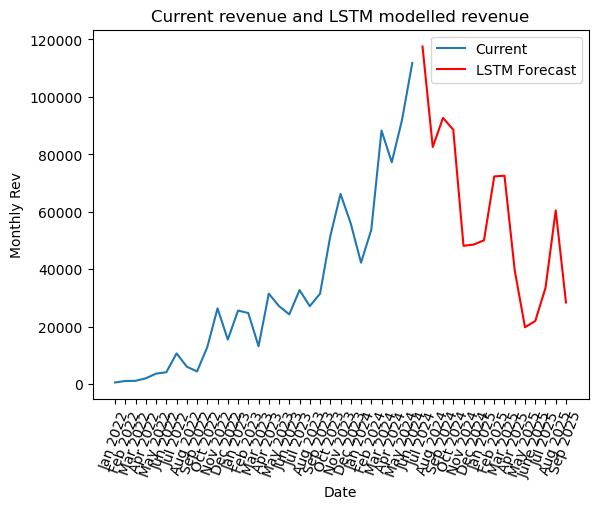

Doesn't generalize well


In [135]:
#create dataframe that shows the predicted sales
result_list = []
#print(revenueDF)
sales_dates = ['Jul 2024','Aug 2024','Sep 2024','Oct 2024','Nov 2024','Dec 2024',
               'Jan 2025','Feb 2025','Mar 2025','Apr 2025','May 2025', 'June 2025', 'Jul 2025', 'Aug 2025', 'Sep 2025'] #list(revenueDF[-18:].Date)
act_sales = revenueDF['Overall'].to_numpy()
for index in range(0,len(sales_dates)):
    result_dict = {}
    result_dict['Pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[-(index+1)])
    result_dict['Date'] = sales_dates[index]
    result_list.append(result_dict)
df_result = pandas.DataFrame(result_list) #for multistep prediction, replace act_sales with the predicted sales

#Plot
#merge with actual sales dataframe
df_sales_pred = pandas.merge(revenueDF,df_result,on='Date',how='left')#plot actual and predicted

#matplot
plt.plot(revenueDF['Date'], revenueDF['Overall'])
plt.plot( df_result['Date'], df_result['Pred_value'] , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 70)
plt.ylabel("Monthly Rev")
plt.legend(["Current", "LSTM Forecast"])
plt.title("Current revenue and LSTM modelled revenue")
plt.show()
print("Doesn't generalize well")

# Compare each model against base return of startups

<img src="https://www.sethlevine.com/wp/wp-content/uploads/venture-returns.png" width="400" height="400">
Good graph of power law return of startups at: https://www.sethlevine.com/archives/2014/08/venture-outcomes-are-even-more-skewed-than-you-think.html

In [136]:
from scipy.stats import gmean
sigmoidMultiple
maxEBITAReturn = (maxShare)/orignal
minEBITAReturn = (minShare)/orignal
sarimaMultiple

print("For a IPO time/buyback:", years)
print("SARIMA Multiple:", sarimaMultiple)
print("Sigmoid Multiple:", sigmoidMultiple)
print("Max EBITA Multiple:", maxEBITAReturn)
print("Max EBITA Multiple:", minEBITAReturn)
print("Geometric mean:", gmean([sarimaMultiple, sigmoidMultiple, maxEBITAReturn, minEBITAReturn]) )

For a IPO time/buyback: 6
SARIMA Multiple: 1.692684055690725
Sigmoid Multiple: 3.3215713751678546
Max EBITA Multiple: 0.03911229452784424
Max EBITA Multiple: 0.018272308588580668
Geometric mean: 0.2517714911510889
